In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from geopy.geocoders import Nominatim
from pandas_ods_reader import read_ods
import math
from pyroutelib3 import Router
from kneed import KneeLocator
import folium
import io
from PIL import Image
import pdfkit

#Set router specification
router = Router("car") 

#Set parameters to geolocate
geolocator = Nominatim(user_agent="useer_agent", domain='nominatim.openstreetmap.org')
geocode = partial(geolocator.geocode, language="it", country_codes = "ita")

#Reachable cities
dft = pd.read_csv("../Dati/distanze/corrected_times_computed.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0)
cities = dft.columns
dfc=pd.read_csv("../Dati/altro/CitiesLocation.csv", delimiter=';')

#Latitudine verticale
lat = dfc["Lat"]
#Longitudine orizzontale
lon = dfc["Lon"]
cities = dfc["City"]

#Arrotondamento delle coordinate minime e massime per dare del margine alla mappa
lonmin = round(lon.min()*100)/100
lonmax = math.ceil(lon.max()*10)/10
latmin = (round(lat.min() * 10)-1)/10
latmax = math.ceil(lat.max()*100)/100

lat = list(dfc['Lat'])
lon = list(dfc['Lon'])
data = np.column_stack((lat, lon))

In [2]:
def getLocation(name):
    geolocator = Nominatim(user_agent="useer_agent")
    geocode = partial(geolocator.geocode, language="it")
    location =geolocator.geocode(name)
    return location.latitude, location.longitude

#Return a mask to get coords in dfc
def getCoords(string, city_list):
    return pd.Series(city_list).str.contains(string, case=False).values

#Crop image by min/max lat/lon of cities passed by argument
#return cropped image, min/man lat/lon and position of cities
def crop(cities_list):
    
    y_positions = [dfc.Lat[getCoords(paese, dfc.City)].values[0] for paese in cities_list.dropna()]
    x_positions = [dfc.Lon[getCoords(paese, dfc.City)].values[0] for paese in cities_list.dropna()]
    
    ruh_m = plt.imread('../Dati/altro/output.png')
    map_sizey, map_sizex, _ = ruh_m.shape
    #Rounding to get margin
    nlonmin = round(min(x_positions)*100)/100
    nlonmax = math.ceil(max(x_positions)*10)/10
    nlatmin = (round(min(y_positions) * 10)-1)/10
    nlatmax = math.ceil(max(y_positions)*100)/100
    #Convert coords to pixel and crop image
    xmin = int(round((map_sizex*(nlonmin-lonmin))/(lonmax-lonmin)))
    xmax = int(round((map_sizex*(nlonmax-lonmin))/(lonmax-lonmin)))
    ymin = int(round(map_sizey*((nlatmin-latmin) / (latmax-latmin))))
    ymax = int(round(map_sizey*((nlatmax-latmin) / (latmax-latmin))))
    return ruh_m[max(0,map_sizey-ymax):max(0,map_sizey-ymin), max(0,xmin):max(0,xmax)], nlonmin, nlonmax, nlatmin, nlatmax, x_positions, y_positions

def get_row(df, string):
    return pd.Series(df.index).str.contains(string, case=False)

def getName(nome):
    city = dft[get_row(dft, nome).values].index[0]
    return city.split(",")[0].strip()

#Return list of track coordinates
def getTrack(city_s, city_e):
    
    lati = dfc.Lat[getCoords(city_s, dfc.City)].values[0]
    long = dfc.Lon[getCoords(city_s, dfc.City)].values[0]
    start = router.findNode(lati, long)

    lati = dfc.Lat[getCoords(city_e, dfc.City)].values[0]
    long = dfc.Lon[getCoords(city_e, dfc.City)].values[0]
    end = router.findNode(lati, long)

    status, route = router.doRoute(start, end) # Find the route - a list of OSM nodes
    
    lat_list=[]
    lon_list=[]

    if status == 'success':
        routeLatLons = list(map(router.nodeLatLon, route)) # Get actual route coordinates
        for el in routeLatLons:
            lat_list.append(el[0])
            lon_list.append(el[1])
    return lat_list, lon_list

In [3]:
(min(lat), max(lat), min(lon), max(lon))

(44.9286315, 45.470343299999996, 9.493822300000001, 10.520690400000001)

In [4]:
(lonmin, latmin, lonmax, latmax)

(9.49, 44.8, 10.6, 45.48)

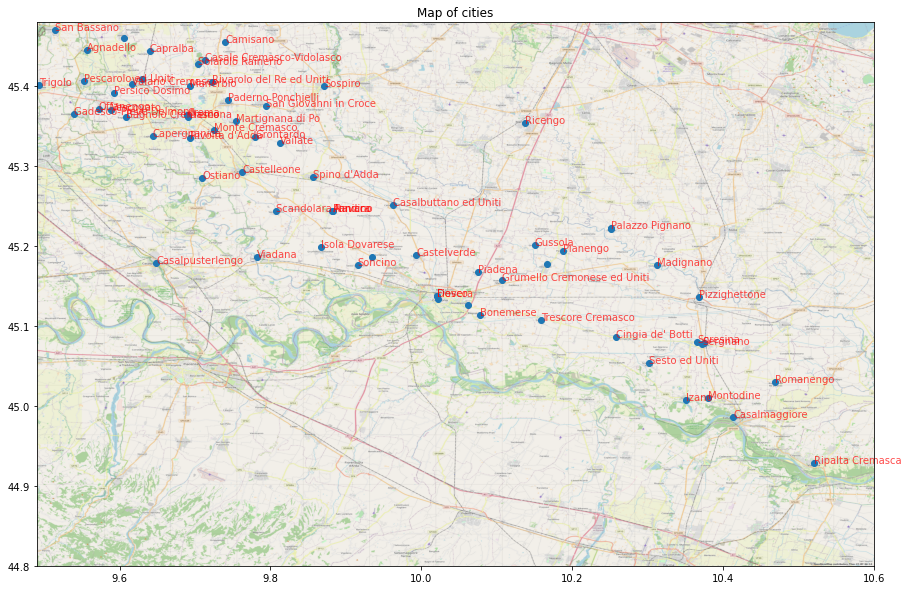

In [32]:
BBox = (lonmin, lonmax,
        latmin, latmax)
ruh_m = plt.imread('../Dati/altro/output.png')

fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(dfc.Lon, dfc.Lat, zorder=1, alpha=1, marker="o")
ax.set_title('Map of cities')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ct = []
for name in cities:
    try:
        ct.append(name[:name.index(",")])
    except:
        ct.append(name)

ct=pd.Series(ct).unique()
for i, txt in enumerate(ct[:len(ct)-1]):
    ax.annotate(txt, (lon[i], lat[i]), zorder=2, alpha=0.7, color="red")
        
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'auto')
plt.show()

In [3]:
def printTrack(day, csv, f, title, plot_index):
    ruh_m, nlonmin, nlonmax, nlatmin, nlatmax, x_positions, y_positions = crop(csv[day])

    BBox = (nlonmin, nlonmax,
            nlatmin, nlatmax)
    
    ax = f.add_subplot(1, 2, plot_index)

    ax.scatter(x_positions, y_positions, zorder=1, alpha=1, marker="o")

    ax.set_title(title)
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    for i, txt in enumerate(csv[day][:len(csv[day].dropna())]):
        try:
            ax.annotate(getName(txt), (x_positions[i], y_positions[i]), zorder=2, aplha=0.5, color='red', fontweight="bold")
        except:
            ax.annotate(getName(txt), (x_positions[i], y_positions[i]), zorder=2, color='red', fontweight="bold")
        if(i>0):
            la, lo = getTrack(prec, txt)
            ax.plot(lo, la, zorder=1, alpha=1, color="black")
        prec = txt

    ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'auto')  

In [10]:
week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
total = []
# for day in week:
#     total += list(f1[day].dropna())

# sweek = ["martedi", "mercoledi", "giovedi"]
# for day in sweek:
#     total += list(f2[day].dropna())
# total = list(set(total))

def printFTrack(cities_list):
    lat = list([dfc.Lat[getCoords(x.strip(), dfc.City)].values[0] for x in cities_list])
    lon = list([dfc.Lon[getCoords(x.strip(), dfc.City)].values[0] for x in cities_list])
    size = np.column_stack((lat, lon))
    map_ = folium.Map(location = size[len(size)-1])
    map_.fit_bounds([[min(lat), min(lon)], [max(lat), max(lon)]], padding=[10,10])
    for i, txt in enumerate(cities_list.dropna()):
        txt=txt.strip()
        #folium.Marker((dfc.Lat[getCoords(txt, dfc.City)], dfc.Lon[getCoords(txt, dfc["City"])]), icon = folium.Icon(color='red'), popup = getName(txt)).add_to(map_)
        lat = dfc.Lat[getCoords(txt, dfc.City)].values[0]
        lon = dfc.Lon[getCoords(txt, dfc.City)].values[0]
        folium.Circle(opacity=0.7, 
                      radius=100, 
                      location = [lat, lon], color='crimson', 
                      fill=True,).add_to(map_)
        folium.Marker((lat, lon), icon=folium.DivIcon(html=f"<div style='font-size: 7pt; font-family: bold; font-weight: 900; alpha=0.5; color : black'>{getName(txt.strip())}</div>")).add_to(map_)
        if i>0 and cities_list[i-1].strip()!=cities_list[i].strip():
            lat_lon_list = np.column_stack(getTrack(cities_list[i-1].strip(), cities_list[i].strip()))
            folium.PolyLine(lat_lon_list, color="#6166ff", weight=1.5, opacity=0.7).add_to(map_)
    return map_

def printFPos(cities_list):
    lat = list([dfc.Lat[getCoords(x.strip(), dfc.City)].values[0] for x in cities_list])
    lon = list([dfc.Lon[getCoords(x.strip(), dfc.City)].values[0] for x in cities_list])
    size = np.column_stack((lat, lon))
    map_ = folium.Map(location = size[len(size)-1])
    #map_.fit_bounds([[min(lat), min(lon)], [max(lat), max(lon)]], padding=[10,10])
    for i, txt in enumerate(cities_list):
        txt=txt.strip()
        if(txt=="Cremona, Sesto 39"):
            folium.Marker((dfc.Lat[getCoords(txt, dfc.City)], dfc.Lon[getCoords(txt, dfc["City"])]), icon = folium.Icon(color='blue'), popup = getName(txt)).add_to(map_)
        else:
            folium.Marker((dfc.Lat[getCoords(txt, dfc.City)], dfc.Lon[getCoords(txt, dfc["City"])]), icon = folium.Icon(color='red'), popup = getName(txt)).add_to(map_)
        lat = dfc.Lat[getCoords(txt, dfc.City)].values[0]
        lon = dfc.Lon[getCoords(txt, dfc.City)].values[0]
#         folium.Circle(opacity=0.7, 
#                       radius=100, 
#                       location = [lat, lon], color='crimson', 
#                       fill=True,).add_to(map_)
#         folium.Marker((lat, lon), 
#                        icon=folium.DivIcon(html=f"<div style='font-size: 10pt; font-family: bold; font-weight: 900; alpha=0.5; color : black'>{getName(txt.strip())}</div>")).add_to(map_)
        
    return map_
#img_data = printFTrack(f1["lunedi"])._to_png(5)
#img = Image.open(io.BytesIO(img_data))
#img.save('prova.png')
#printFTrack(f1["lunedi"]).save('map.html')

#printFPos(pd.Series(total))

In [11]:
f1 = pd.read_csv("../Dati/turni_f/optimized_start/optimized_start_schedule.csv", sep=";", encoding = "ISO-8859-1")
total = []
for day in week:
    total += list(f1[day].dropna())
m = printFPos(total)
m.save("idnex.html")

In [42]:
#GREEDY
#f1 = pd.read_csv("../Dati/turni_f/furgoncino1_routing.csv", sep=";", encoding = "ISO-8859-1")
#f2 = pd.read_csv("../Dati/turni_f/furgoncino2_routing.csv", sep=";", encoding = "ISO-8859-1")
#LOCAL SEARCH
#f1 = pd.read_csv("../Dati/turni_f/ls1_shifts.csv", sep=";", encoding = "ISO-8859-1")
#f2 = pd.read_csv("../Dati/turni_f/ls2_shifts.csv", sep=";", encoding = "ISO-8859-1")
#2-OPT
#f1 = pd.read_csv("../Dati/turni_f/2-opt1_shifts.csv", sep=";", encoding = "ISO-8859-1")
#f2 = pd.read_csv("../Dati/turni_f/2-opt2_shifts.csv", sep=";", encoding = "ISO-8859-1")
#MULTI-VEHICLE LOCAL SEARCH
f1 = pd.read_csv("../Dati/turni_f/multi_veich_LS1.csv", sep=";", encoding = "ISO-8859-1")
f2 = pd.read_csv("../Dati/turni_f/multi_veich_LS2.csv", sep=";", encoding = "ISO-8859-1")
week = ["lunedi", "martedi", "mercoledi", "giovedi", "venerdi"]
printFTrack(f1["lunedi"].dropna())

In [43]:
printFTrack(f1["martedi"].dropna())

In [44]:
printFTrack(f1["mercoledi"].dropna())

In [45]:
printFTrack(f1["giovedi"].dropna())

In [46]:
printFTrack(f1["venerdi"].dropna())

In [47]:
printFTrack(f2["martedi"].dropna())

In [48]:
printFTrack(f2["mercoledi"].dropna())

In [49]:
printFTrack(f2["giovedi"].dropna())

In [69]:
def printComparisonTrack(day, vehicle):
    if(vehicle == 1):
        fg = pd.read_csv("../Dati/turni_f/furgoncino1_routing.csv", sep=";", encoding = "ISO-8859-1")
        fls = pd.read_csv("../Dati/turni_f/ls1_shifts.csv", sep=";", encoding = "ISO-8859-1")
        f2opt = pd.read_csv("../Dati/turni_f/2-opt1_shifts.csv", sep=";", encoding = "ISO-8859-1")
        fmvls = pd.read_csv("../Dati/turni_f/multi_veich_LS1.csv", sep=";", encoding = "ISO-8859-1")
    else:
        fg = pd.read_csv("../Dati/turni_f/furgoncino2_routing.csv", sep=";", encoding = "ISO-8859-1")
        fls = pd.read_csv("../Dati/turni_f/ls2_shifts.csv", sep=";", encoding = "ISO-8859-1")
        f2opt = pd.read_csv("../Dati/turni_f/2-opt2_shifts.csv", sep=";", encoding = "ISO-8859-1")
        fmvls = pd.read_csv("../Dati/turni_f/multi_veich_LS2.csv", sep=";", encoding = "ISO-8859-1")
    dataframes = [fg, fls, f2opt, fmvls]
    clrs = ["#6166ff", "#c203fc", "#fc8c03", "#008c15"]
    
    map_ = folium.Map()
    for x in range(len(dataframes)):
        cities_list = dataframes[x][day].dropna()
        clr = clrs[x]
        lat = list([dfc.Lat[getCoords(x.strip(), dfc.City)].values[0] for x in cities_list])
        lon = list([dfc.Lon[getCoords(x.strip(), dfc.City)].values[0] for x in cities_list])
        size = np.column_stack((lat, lon))
        map_.fit_bounds([[min(lat), min(lon)], [max(lat), max(lon)]], padding=[10,10])
        for i, txt in enumerate(cities_list.dropna()):
            txt=txt.strip()
            #folium.Marker((dfc.Lat[getCoords(txt, dfc.City)], dfc.Lon[getCoords(txt, dfc["City"])]), icon = folium.Icon(color='red'), popup = getName(txt)).add_to(map_)
            lat = dfc.Lat[getCoords(txt, dfc.City)].values[0]
            lon = dfc.Lon[getCoords(txt, dfc.City)].values[0]
            folium.Circle(opacity=0.7, 
                          radius=100, 
                          location = [lat, lon], color='crimson', 
                          fill=True,).add_to(map_)
            folium.Marker((lat, lon), icon=folium.DivIcon(html=f"<div style='font-size: 7pt; font-family: bold; font-weight: 900; alpha=0.5; color : black'>{getName(txt.strip())}</div>")).add_to(map_)
            if i>0 and cities_list[i-1].strip()!=cities_list[i].strip():
                lat_lon_list = np.column_stack(getTrack(cities_list[i-1].strip(), cities_list[i].strip()))
                plln = folium.PolyLine(lat_lon_list, color = clr, weight=2, opacity=0.7)
                plln.add_to(map_)
    return map_

printComparisonTrack("lunedi", 1)

In [70]:
printComparisonTrack("martedi", 1)

In [71]:
printComparisonTrack("mercoledi", 1)

In [72]:
printComparisonTrack("giovedi", 1)

In [73]:
printComparisonTrack("venerdi", 1)

In [74]:
printComparisonTrack("martedi", 2)

In [75]:
printComparisonTrack("mercoledi", 2)

In [76]:
printComparisonTrack("giovedi", 2)

In [ ]:
lat = list(dfc['Lat'])
lon = list(dfc['Lon'])
data = np.column_stack((lat, lon))
print(type(data))
map_ = folium.Map(location = data[len(data)-1])
for i, txt in enumerate(f1["lunedi"].dropna()):
    txt=txt.strip()
    #folium.Marker((dfc.Lat[getCoords(txt, dfc.City)], dfc.Lon[getCoords(txt, dfc["City"])]), icon = folium.Icon(color='red'), popup = getName(txt)).add_to(map_)
    folium.Marker((dfc.Lat[getCoords(txt, dfc.City)], dfc.Lon[getCoords(txt, dfc["City"])]), icon=folium.DivIcon(html=f"<div style='font-size: 7pt; font-family: bold; font-weight: 900; color : black'>{getName(txt.strip())}</div>")).add_to(map_)
    if i>0:
        lat_lon_list = np.column_stack(getTrack(f1["lunedi"][i-1].strip(), f1["lunedi"][i].strip()))
        folium.PolyLine(lat_lon_list, color="#6166ff", weight=1.5, opacity=0.7).add_to(map_)
    
map_

In [72]:
map_ = folium.Map(location = data[len(data)-1])
for i, txt in enumerate(f1["lunedi"].dropna()):
    txt=txt.strip()
    folium.Marker((dfc.Lat[getCoords(txt, dfc.City)], dfc.Lon[getCoords(txt, dfc["City"])]), icon=folium.DivIcon(html=f"<div style='font-size: 7pt; font-family: bold; color : black'>{getName(txt.strip())}</div>")).add_to(map_)

map_

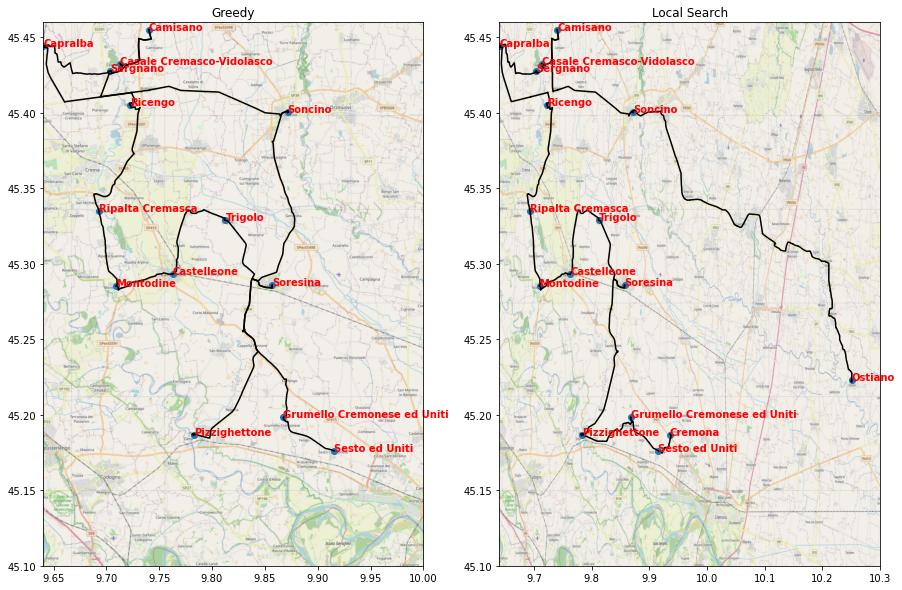

In [69]:
day="lunedi"
f1 = pd.read_csv("../Dati/turni_f/furgoncino1_routing.csv", sep=";")
f = plt.figure(figsize=(15,10))
printTrack(day, f1, f, "Greedy", 1)

f1 = pd.read_csv("../Dati/turni_f/ls1_shifts.csv", sep=";")
printTrack(day, f1, f, "Local Search", 2)

plt.show()
